In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import proylib

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_10512/3575814356.py:5: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-07 14:53:21 Configured OSMnx 1.1.2
2024-01-07 14:53:21 HTTP response caching is on


## Download data

### Guadalajara hexagons

In [3]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'

query = f"SELECT * FROM {schema}.{folder} WHERE \"CVEGEO\" = \'14039\'"

hex_gdf = proylib.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c9616bffff,"POLYGON ((-103.35105 20.65207, -103.34983 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban


### Nodes, edges

In [4]:
hex_gdf = hex_gdf.set_crs("EPSG:4326")

G,nodes,edges = proylib.graph_from_hippo(hex_gdf, schema='osmnx', 
                    edges_folder='edges_speed', nodes_folder='nodes_elevation')

2024-01-07 14:55:17 Created graph from node/edge GeoDataFrames


## Access to job analysis

In [6]:
from tqdm import tqdm

Create isochrone by node

In [7]:
folder_denue = 'denue'
table_denue = 'denue_2022'

osmid_isochrone = {}

nodes_job = nodes.reset_index()[['osmid','geometry']].copy()

for i in tqdm(range(len(nodes_job)), position=0, leave=True):
    osmid = nodes_job.iloc[i].osmid
    # create isochrone
    iso_geom = proylib.calculate_isochrone(G, osmid, 30, dist_column='time_min')
    
    osmid_isochrone[osmid] = iso_geom

100%|████████████████████████████████████████████████████████| 33956/33956 [1:15:18<00:00,  7.51it/s]


In [8]:
iso_df = pd.DataFrame.from_dict(osmid_isochrone, orient='index').reset_index().rename(columns={'index':'osmid',0:'geometry'})
print(iso_df.shape)
iso_df.head(4)

(33956, 2)


,osmid,geometry
0,28751344,"POLYGON ((-103.3085567 20.6972379, -103.312141..."
1,28753224,"POLYGON ((-103.3151964 20.6864678, -103.325197..."
2,28757751,"POLYGON ((-103.3080782 20.6944792, -103.309356..."
3,28757777,"POLYGON ((-103.3090265 20.6956042, -103.313046..."


Download DENUE

In [9]:
iso_gdf = gpd.GeoDataFrame(
    iso_df, geometry='geometry')
iso_gdf = iso_gdf.set_crs("EPSG:4326")

In [10]:
gdf_tmp = iso_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry('geometry')
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [11]:
folder_denue = 'denue'
table_denue = 'denue_2020'

# download denue
query = f"SELECT * FROM {folder_denue}.{table_denue} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"

denue = proylib.gdf_from_query(query, geometry_col='geometry')

print(denue.shape)
denue.head(4)

(103050, 42)


,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipo_uni_eco,latitud,longitud,fecha_alta,geometry
0,8606103.0,SOLUCIONES LIGERAS ARCH,SOLUCIONES LIGERAS ARCH SA,238312.0,"Trabajos de enyesado, empastado y tiroleado",31 a 50 personas,CALZADA,JUAN PABLO II,CALLE,SAN ESTEBAN,...,0793,8.0,nan,None,None,Fijo,20.689720,-103.315790,2019-11,POINT (-103.31579 20.68972)
1,1956159.0,ARTICULOS UNICOS EN PIEL RM & F,ARTICULOS UNICOS EN PIEL RM & F SA DE CV,316999.0,"Fabricación de otros productos de cuero, piel ...",11 a 30 personas,CALLE,MONTE BELLO,CALLE,SAN MARIANO,...,0789,13.0,nan,None,None,Fijo,20.690737,-103.315690,2010-07,POINT (-103.31569 20.69074)
2,9095617.0,CALZADO JOAN PETIT,None,316211.0,Fabricación de calzado con corte de piel y cuero,6 a 10 personas,CALLE,JOSE MARIA GOMEZ,CALLE,SAN ILDEFONSO,...,0806,35.0,nan,None,None,Fijo,20.684162,-103.314740,2019-11,POINT (-103.31474 20.68416)
3,7052959.0,FABRICA DE CALZADO CON CORTE DE PIEL Y CUERO S...,None,316211.0,Fabricación de calzado con corte de piel y cuero,0 a 5 personas,CALLE,SAN ESTEBAN,CALLE,MONTE BELLO,...,0789,3.0,nan,None,None,Fijo,20.690971,-103.315506,2019-11,POINT (-103.31551 20.69097)


Access to jobs

In [12]:
def clip_denue(denue, geom, denue_size_dict):
    # clip denue into gdf
    denue_clip = gpd.clip(denue, geom)
        
    # jobs data to nodes
    total_denue = denue_clip.shape[0]
    total_jobs = denue_clip.per_ocu_num.sum()
    
    job_dict = {}
    denue_size_list = []

    for denue_size in denue_size_dict.keys():
        denue_size_list.append(denue_size)
        job_dict[denue_size] = denue_clip.loc[denue_clip.per_ocu==denue_size_dict[denue_size]].shape[0]
    
    return (total_denue, total_jobs, job_dict[denue_size_list[0]],
            job_dict[denue_size_list[1]], job_dict[denue_size_list[2]],
            job_dict[denue_size_list[3]], job_dict[denue_size_list[4]],
            job_dict[denue_size_list[5]], job_dict[denue_size_list[6]])

In [14]:
denue_size_dict = {'denue_0_5':'0 a 5 personas',
                'denue_6_10':'6 a 10 personas',
                'denue_11_30':'11 a 30 personas',
                'denue_31_50':'31 a 50 personas',
                'denue_51_100':'51 a 100 personas',
                'denue_101_250':'101 a 250 personas',
                'denue_250_mas':'251 y más personas'}

In [16]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [17]:
denue['per_ocu_num'] = denue.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [18]:
# calculate jobs
job_analysis_columns = ['denue_count','denue_jobs','denue_0_5','denue_6_10',
                    'denue_11_30','denue_31_50','denue_51_100',
                    'denue_101_250','denue_250_mas']

for i in tqdm(range(len(iso_gdf)), position=0, leave=True):
    
    osmid = iso_gdf.iloc[i].osmid
    geom = iso_gdf.iloc[i].geometry
    
    if geom.geom_type=='Point' or geom.geom_type=='LineString':
        continue

    # create isochrone
    iso_gdf.loc[iso_gdf.osmid==osmid, job_analysis_columns] = clip_denue(denue, geom, denue_size_dict)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33956/33956 [17:26<00:00, 32.45it/s]


In [19]:

nodes_job_data = nodes_job.merge(iso_gdf.drop(columns=['geometry']), on='osmid', how='left')
print(nodes_job_data.shape)
nodes_job_data.head(4)

(33956, 11)


,osmid,geometry,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas
0,28751344,POINT (-103.30631 20.71153),3427.0,17953.0,3037.0,189.0,159.0,20.0,11.0,7.0,4.0
1,28753224,POINT (-103.31665 20.70065),4417.0,22039.0,3851.0,302.0,208.0,34.0,16.0,4.0,2.0
2,28757751,POINT (-103.30736 20.70853),3732.0,18865.0,3302.0,218.0,167.0,20.0,16.0,7.0,2.0
3,28757777,POINT (-103.30681 20.71009),3721.0,18705.0,3292.0,218.0,168.0,20.0,14.0,7.0,2.0


Node data to hex

In [20]:
hex_job = proylib.group_by_hex_mean(nodes_job_data, hex_gdf, 9, 'denue_count')
print(hex_job.shape)
hex_job.head(4)

(1214, 15)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas
0,89498c94383ffff,"POLYGON ((-103.31114 20.70199, -103.30992 20.7...",14039,Guadalajara,Guadalajara,urban,4050.800000,20316.800000,3570.650000,249.200000,183.200000,25.400000,13.550000,6.300000,2.500000
1,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,11895.862069,116252.344828,8842.137931,1547.896552,1013.120690,194.810345,139.879310,83.724138,74.293103
2,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,2983.800000,39387.028571,2279.628571,265.428571,238.028571,66.800000,61.171429,34.914286,37.828571
3,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban,3491.454545,15015.181818,3205.454545,176.272727,88.272727,6.090909,8.590909,5.772727,1.000000


Economical unit size

In [21]:
hex_job['denue_jobs_>_11'] = hex_job['denue_jobs'] - hex_job['denue_0_5'] * 3 - hex_job['denue_6_10'] * 8
hex_job['pct_jobs_>_11'] = hex_job['denue_jobs_>_11'] / hex_job['denue_jobs']

In [22]:
hex_job.to_file('../data/processed/hex_denue.geojson')

## Proximity to tianguis

In [8]:
tianguis_gdf = gpd.read_file('../data/processed/tianguis_point.shp')
tianguis_gdf = tianguis_gdf.to_crs("EPSG:4326")
print(tianguis_gdf.shape)
tianguis_gdf.head(2)

(20742, 13)


,fid,cat,Nombre_del,Tipo,Nombre_de0,Longitud__,vertex_pos,vertex_ind,vertex_par,vertex_p_1,distance,angle,geometry
0,1.0,1,GUADALAJARA,REGULAR,MELCHOR MUZQUIZ,181.46,0,0,0,0,0.00000,212.66563,POINT (-103.31883 20.65242)
1,1.0,1,GUADALAJARA,REGULAR,MELCHOR MUZQUIZ,181.46,-1,1,0,1,9.55078,212.66563,POINT (-103.31888 20.65235)


In [10]:
tianguis_osmid = proylib.find_nearest(G, nodes, tianguis_gdf, return_distance= True)
nodes_tianguis = proylib.calculate_distance_nearest_poi(tianguis_osmid, nodes, 
                                       edges, 'tianguis', 'osmid', wght='time_min')
nodes_tianguis = nodes_tianguis.reset_index()
nodes_tianguis.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_tianguis
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),2.523255
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),5.730982
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),1.394160
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),0.000000


In [14]:
nodes_tianguis = nodes_tianguis.to_crs("EPSG:32613")
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_eco = proylib.group_by_hex_mean(nodes_tianguis, hex_gdf, 9, 'dist_tianguis')
print(hex_eco.shape)
hex_eco.head(2)

(1214, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_tianguis
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,13.406640
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,1542.655172,10.794146


<AxesSubplot: >

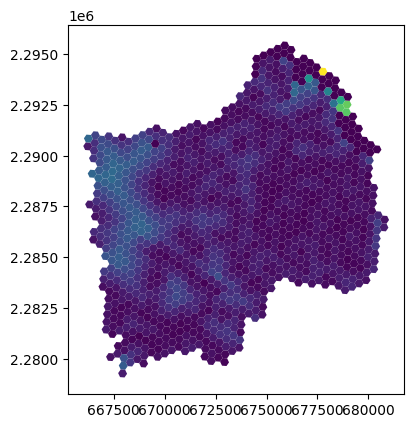

In [15]:
hex_eco.plot('dist_tianguis')

## Proximity to mercados

In [20]:
mercados_gdf = gpd.read_file('../data/processed/mercados_amg.geojson')
mercados_gdf = mercados_gdf.to_crs("EPSG:4326")
print(mercados_gdf.shape)
mercados_gdf.head(2)

(179, 4)


,Nombre_del,Nombre_de0,Categor�a_,geometry
0,GUADALAJARA,REFORMA (FEDERACI�N),TERCERA CATEGOR�A,POINT (-103.33566 20.67907)
1,GUADALAJARA,PASAJE MORELOS,PRIMERA CATEGOR�A,POINT (-103.34787 20.67695)


In [21]:
mercados_osmid = proylib.find_nearest(G, nodes, mercados_gdf, return_distance= True)
nodes_mercado = proylib.calculate_distance_nearest_poi(mercados_osmid, nodes, 
                                       edges, 'mercado', 'osmid', wght='time_min')
nodes_mercado = nodes_mercado.reset_index()
nodes_mercado.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_mercado
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),9.637074
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),10.080722
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),11.240130
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),12.160329


In [26]:
nodes_mercado = nodes_mercado.to_crs("EPSG:32613")
hex_mercado = proylib.group_by_hex_mean(nodes_mercado, hex_gdf, 9, 'dist_mercado')
print(hex_mercado.shape)
hex_mercado.head(2)

(1214, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_mercado
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,20.115345
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,1542.655172,11.302824


## Merge hexagon data

In [27]:
hex_eco = hex_eco.merge(hex_mercado[['hex_id_9','dist_mercado']],
                       on='hex_id_9', how='outer')
hex_eco.head(2)

,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_tianguis,dist_mercado
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,13.406640,20.115345
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,1542.655172,10.794146,11.302824


In [29]:
hex_denue = gpd.read_file('../data/processed/hex_denue.geojson')
hex_denue.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,geometry
0,89498c94383ffff,14039,Guadalajara,Guadalajara,urban,4050.800000,20316.800000,3570.650000,249.200000,183.20000,25.400000,13.55000,6.300000,2.500000,7611.250000,0.374628,"POLYGON ((-103.31114 20.70199, -103.30992 20.7..."
1,89498c96e0bffff,14039,Guadalajara,Guadalajara,urban,11895.862069,116252.344828,8842.137931,1547.896552,1013.12069,194.810345,139.87931,83.724138,74.293103,77342.758621,0.665301,"POLYGON ((-103.35267 20.66765, -103.35145 20.6..."


In [31]:
hex_eco = hex_eco.merge(hex_denue[['hex_id_9','denue_count',
                        'denue_jobs','denue_0_5',
                        'denue_6_10','denue_11_30',
                        'denue_31_50','denue_51_100',
                        'denue_101_250','denue_250_mas',
                        'denue_jobs_>_11','pct_jobs_>_11']],
             on='hex_id_9', how='outer')
print(hex_eco.shape)
hex_eco.head(2)

(1214, 24)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,...,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,...,35226.176471,1576.411765,393.000000,310.294118,68.529412,60.411765,35.588235,23.529412,27352.941176,0.776495
1,89498c96e0bffff,"POLYGON ((671598.887 2286237.521, 671724.122 2...",14039,Guadalajara,Guadalajara,urban,93306.603448,-103.353999,20.669368,3.413793,...,116252.344828,8842.137931,1547.896552,1013.120690,194.810345,139.879310,83.724138,74.293103,77342.758621,0.665301


In [32]:
hex_eco.to_file('../data/processed/hex_economic.geojson')